## Formal Update 7/20/2021
### Zach Shelton

In [3]:
import awkward1 as ak
import uproot
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
import coffea
from uproot3_methods import TLorentzVectorArray
import numpy as np
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"
import coffea.processor as processor
from pprint import pprint
file=uproot.open(files)
from pprint import pprint

### Table of Contents:

1. Data Preprocessing and Goals for data usage
2. Relevant data per combo and event
3. Model Structure and Parameters

______________________________________________________________________

The data used is event data in the NanoAOD format:

In [4]:
events=NanoEventsFactory.from_root(files,schemaclass=HackSchema,entry_stop=10000).events()

C:\Users\zshel\anaconda3\envs\py38\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
C:\Users\zshel\anaconda3\envs\py38\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
C:\Users\zshel\anaconda3\envs\py38\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
C:\Users\zshel\anaconda3\envs\py38\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
C:\Users\zshel\anaconda3\envs\py38\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
C:\Users\zshel\anaconda3\envs\py38\lib\site-pa

In [5]:
events.fields

['PV',
 'Muon',
 'Electron',
 'LHEScaleWeight',
 'LHEPart',
 'HLT',
 'event',
 'GenJet',
 'Generator',
 'run',
 'L1PreFiringWeight',
 'LHEPdfWeight',
 'PSWeight',
 'GenPart',
 'L1',
 'fixedGridRhoFastjetAll',
 'Jet',
 'MET',
 'L1simulation',
 'luminosityBlock',
 'Flag',
 'GenMET',
 'Pileup',
 'LHEWeight']

In [6]:
#Condensing_all Lepton_cuts
jets=events.Jet
jetSel = (jets.pt>30) & (abs(jets.eta)<2.4)
tightJet = jets[jetSel]
#Selecting Jets
bJet = tightJet[tightJet.btagDeepFlavB > 0.642]
muons = events.Muon
muonSel = (muons.pt>30) & (abs(muons.eta)<2.4)
tightMuon = muons[muonSel]
#Selecting Events that have decaying leptons
ele = events.Electron
eleSel = (ele.pt>35)&(abs(ele.eta)<2.4)
tightEle = ele[eleSel]
eventSel = (((ak.num(tightMuon)==1) | (ak.num(tightEle)==1)) &
            (ak.num(tightJet)>= 3) & (ak.num(bJet)>=1)
           )
final=events[eventSel]

We will be using the GenPart and GenJet columns to match the Jets

We are looking for occurences of hadronically decaying tops:
t->bW->bqq.

First we will identify top quarks using pdgId.

(Link to pdgid number scheme: https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)

In [7]:
genPart = final.GenPart
tops = genPart[abs(genPart.pdgId)==6]
print(tops.pdgId[0:3])
#The isLastCopy Flag filters out copy Genparticles:
tops = tops[tops.hasFlags('isLastCopy')]
print(tops.pdgId[0:3])

[[6, -6, 6, -6], [6, -6, 6, -6], [6, -6, 6, -6]]
[[6, -6], [6, -6], [6, -6]]


GenPart has the function distinctChildren and distinctParent respectively, using distinctChildren on tops returns top decays products:

In [8]:
tDecay = tops.distinctChildren
tDecay = tDecay[tDecay.hasFlags('isLastCopy')]
print(tDecay.pdgId[0:3])

[[[24, 5], [-24, -5]], [[24, 5], [-24, -5]], [[24, 5], [-24, -5]]]


Isolating the W boson(+-24) and the bottom(+-5):

In [9]:
t_Events=tDecay[abs(tDecay.pdgId)==5]
W = tDecay[abs(tDecay.pdgId)==24]
W = W[W.hasFlags('isLastCopy')]
WDecay = W.distinctChildren
WDecay = WDecay[WDecay.hasFlags('isLastCopy')]
#t_events is the lone bottom, W_events is the -> two jets
print("W Decay")
print(WDecay[0:3].pdgId)
print("Filtering out non-hadronically deacaying product(ie light quarks only)")
#select the hadronically decaying W
W_Events=ak.flatten(WDecay[ak.all(abs(WDecay.pdgId)<=8,axis=-1)],axis=3)
print(W_Events[0:3].pdgId)
#print(qqb)

W Decay
[[[[2, -1]], [[15, -16]]], [[[4, -3]], [[13, -14]]], [[[-11, 12]], [[1, -2]]]]
Filtering out non-hadronically deacaying product(ie light quarks only)
[[[2, -1], []], [[4, -3], []], [[], [1, -2]]]


Create a mask for the quark decay events using W_Events:

In [10]:
#HadW is mask for Quark deacying W boson
hadW = ak.num(W_Events,axis=2)==2
#filters out t_events that have a hadronically decayign W Boson
hadB = t_Events[hadW]
hadB = ak.flatten(hadB,axis=2)
print(len(hadB))
print("this will only contian bottom quarks, from events that have hadronic W bosons")
print(hadB.pdgId[0:3])
W_quarks = W_Events[hadW]
W_quarks = ak.flatten(W_quarks,axis=2)
print(len(hadW))
#concatentating these two arrays make an array of events with the correctly decaying GenParticles.
qqb = ak.concatenate([hadB,W_quarks],axis=1)
print(len(qqb))
print("The final correct combinations")
print(qqb[0:3].pdgId)
#lets filter for only 1 HadronicW
#This last mask just gets rid of events that conatin more than one hadronic top

5947
this will only contian bottom quarks, from events that have hadronic W bosons
[[5], [5], [-5]]
5947
5947
The final correct combinations
[[5, 2, -1], [5, 4, -3], [-5, 1, -2]]


In [11]:
#Filtering Out events with extra tops
final=final[(ak.count(qqb.pdgId,axis=1)==3)]
finaljets=final.Jet
qqb=qqb[(ak.count(qqb.pdgId,axis=1)==3)]

In [12]:
#Implementing Tight Jet Cuts on Training Data
finaljetSel=(abs(finaljets.eta)<2.4)&(finaljets.pt>30)
finalJets=finaljets[finaljetSel]

In [13]:
print(len(ak.flatten(finalJets[(abs(finalJets.eta)<2.4)])))
print(len(ak.flatten(finalJets)))

27664
27664


In [14]:
matchedGenJets=qqb.nearest(final.GenJet)
print(matchedGenJets.eta[0:3])
print(matchedGenJets.partonFlavour[0:3])
print(qqb.pdgId[0:3])

[[0.427, 0.29, 1.42], [1.05, 0.703, 1.05], [-1.04, -0.225, 0.735]]
[[5, 2, -1], [-3, 4, -3], [-5, 1, -2]]
[[5, 2, -1], [5, 4, -3], [-5, 1, -2]]


In [15]:
#matchedJets=qqb.nearest(finalJets)
matchedJets=matchedGenJets.nearest(finalJets)
print(len(ak.flatten(matchedJets)))
print(len(ak.flatten(matchedJets[(abs(matchedJets.eta)<2.4)])))

17460
17460


In [16]:
print(matchedJets.partonFlavour[0:3])

[[5, 2, -1], [-3, 4, -3], [-5, 1, -2]]


Passing the reconstructed GenPart through the eventSel will fix mismatch array lengths

In [17]:
test=matchedJets.genJetIdx
combs=ak.combinations(finalJets,3,replacement=False)
t1=(combs['0'].genJetIdx==test[:,0])|(combs['0'].genJetIdx==test[:,1])|(combs['0'].genJetIdx==test[:,2])
t2=(combs['1'].genJetIdx==test[:,0])|(combs['1'].genJetIdx==test[:,1])|(combs['1'].genJetIdx==test[:,2])
t3=(combs['2'].genJetIdx==test[:,0])|(combs['2'].genJetIdx==test[:,1])|(combs['2'].genJetIdx==test[:,2])
t=t1&t2&t3
trutharray=ak.flatten(t)
print(len(trutharray))

65243


In [18]:
print(t1[1])
print(t2[1])
print(t3[1])
print(t[1])

[False, False, False, False, False, False, True, True, True, False]
[True, True, True, False, False, True, False, False, True, True]
[False, True, False, True, False, False, True, False, False, False]
[False, False, False, False, False, False, False, False, False, False]


In [19]:
print(t1[0,5])
print(t2[0,5])
print(t3[0,5])
print(t[0,5])

True
True
True
True


In [20]:
print(t1[1])
print(t2[1])
print(t3[1])
print(t[1])

[False, False, False, False, False, False, True, True, True, False]
[True, True, True, False, False, True, False, False, True, True]
[False, True, False, True, False, False, True, False, False, False]
[False, False, False, False, False, False, False, False, False, False]


We can plot the resulting combos mass to compare the good combos, bad combos, and the Genpart reco mass.

In [21]:
jetcombos=ak.flatten(combs)
genpart_vals=ak.combinations(qqb,3)
good_vals=jetcombos[trutharray]
print(len(good_vals))
bad_vals=jetcombos[np.invert(trutharray)]
print(len(bad_vals))

3598
61645


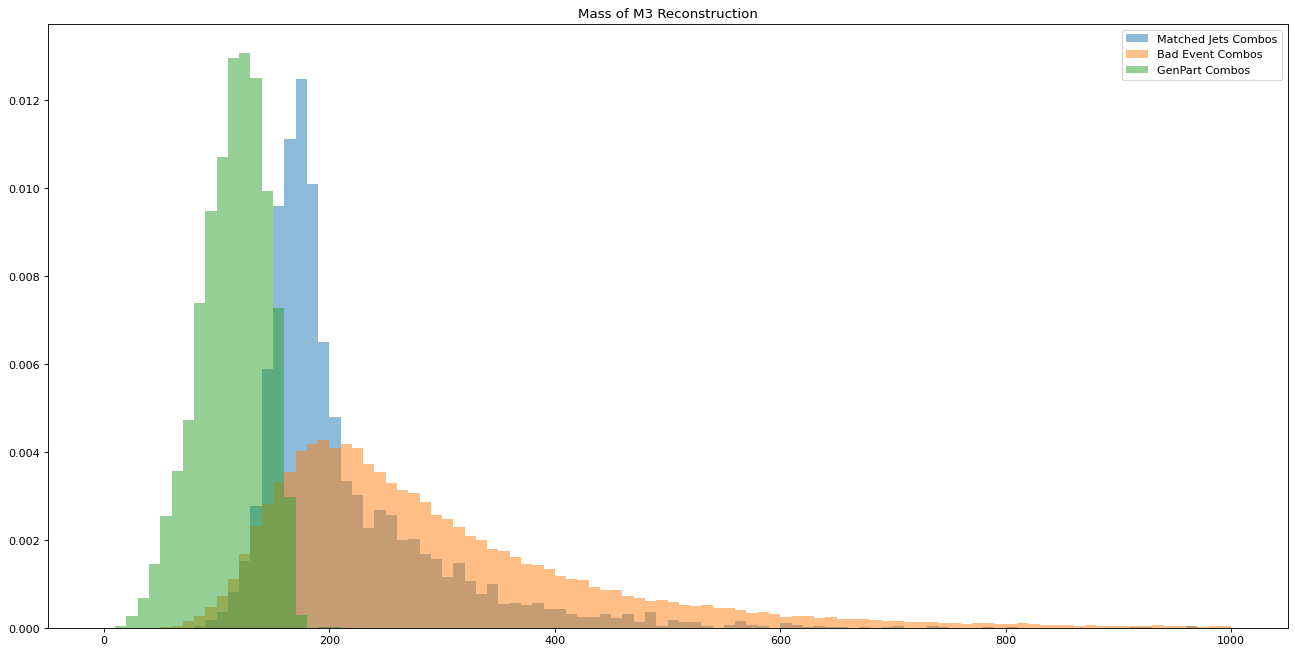

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
bins1=[]
n=0
while n*5<=500:
    bins1.append(n*10)
    n+=1
plt.figure(figsize=(20,10),dpi=80)
greco=good_vals['0']+good_vals['1']+good_vals['2']
breco=bad_vals['0']+bad_vals['1']+bad_vals['2']
genreco=genpart_vals['0']+genpart_vals['1']+genpart_vals['2']
plt.hist(greco.mass,alpha=.5,density=True,bins=bins1)
plt.hist(breco.mass,alpha=.5,density=True,bins=bins1)
plt.hist(ak.flatten(genreco.mass),alpha=.5,density=True,bins=bins1)
plt.legend(["Matched Jets Combos","Bad Event Combos","GenPart Combos"])
plt.title("Mass of M3 Reconstruction")
plt.show()
plt.savefig("Mass.png")

In [23]:
print(np.mean(greco.mass))
print(np.mean(breco.mass))
print(np.mean(ak.flatten(genreco.mass)))

214.72026125625348
302.298223700219
114.1648410652921


# Relevant Features:

## Per Combinations of Jets:

### Each Jet:
* $P_t$
* $ \eta $
* $ \phi $
* mass
* b_tag

### $ \Delta R $ Between Jets
* 1 & 3
* 2 & 3
* 1 & 2

### Potentially Included
* Event Number



In [24]:
### Plot Distribution of Features to be utilized by model

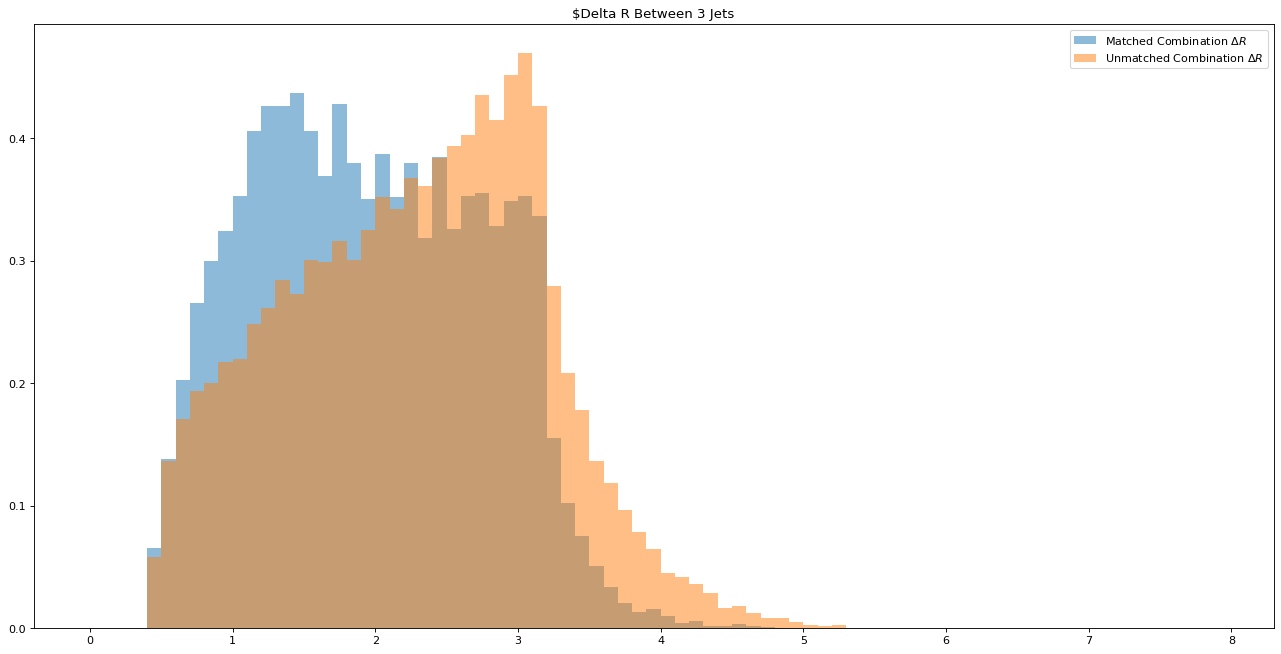

<Figure size 432x288 with 0 Axes>

In [25]:
gdelta12=good_vals['0'].delta_r(good_vals['1'])
gdelta23=good_vals['1'].delta_r(good_vals['2'])
gdelta13=good_vals['0'].delta_r(good_vals['2'])
gdelta=ak.concatenate([gdelta12,gdelta23,gdelta13])
bdelta12=bad_vals['0'].delta_r(bad_vals['1'])
bdelta23=bad_vals['1'].delta_r(bad_vals['2'])
bdelta13=bad_vals['0'].delta_r(bad_vals['2'])
bdelta=ak.concatenate([bdelta12,bdelta23,bdelta13])
plt.figure(figsize=(20,10),dpi=80)
bins1=[]
n=0
while n<80:
    bins1.append(n*.1)
    n=n+1
l=plt.hist(gdelta,alpha=.5,density=True,bins=bins1)
l=plt.hist(bdelta,alpha=.5,density=True,bins=bins1)
plt.legend(["Matched Combination $ \Delta R $","Unmatched Combination $ \Delta R $"])
plt.title("$Delta R Between 3 Jets")
plt.show()
plt.savefig("DeltaR.png")

$ \Delta R $ of the unmatched data favors a Delta R between jets. Noticeably:

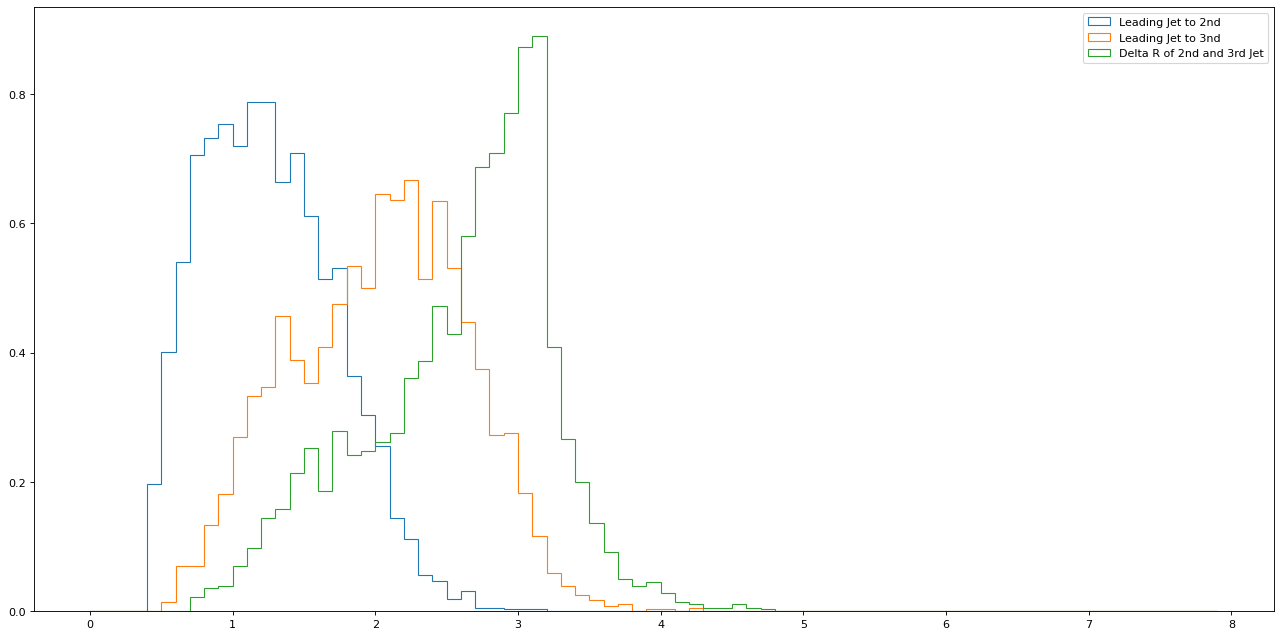

In [29]:
bnpd12=ak.to_numpy(bdelta12)
bnpd13=ak.to_numpy(bdelta13)
bnpd23=ak.to_numpy(bdelta23)
bzipdr=ak.sort(np.stack((bnpd12,bnpd13,bnpd23),axis=1))
npd12=ak.to_numpy(gdelta12)
npd13=ak.to_numpy(gdelta13)
npd23=ak.to_numpy(gdelta23)
zipdr=ak.sort(np.stack((npd12,npd13,npd23),axis=1))
plt.figure(figsize=(20,10),dpi=80)
l=plt.hist(zipdr[:,0],density=True,bins=bins1,histtype='step')
l=plt.hist(zipdr[:,1],density=True,bins=bins1,histtype='step')
l=plt.hist(zipdr[:,2],density=True,bins=bins1,histtype='step')
#l=plt.hist(bzipdr[:,0],density=True,bins=bins1,histtype='step')
plt.legend(['Leading Jet to 2nd','Leading Jet to 3nd','Delta R of 2nd and 3rd Jet'])

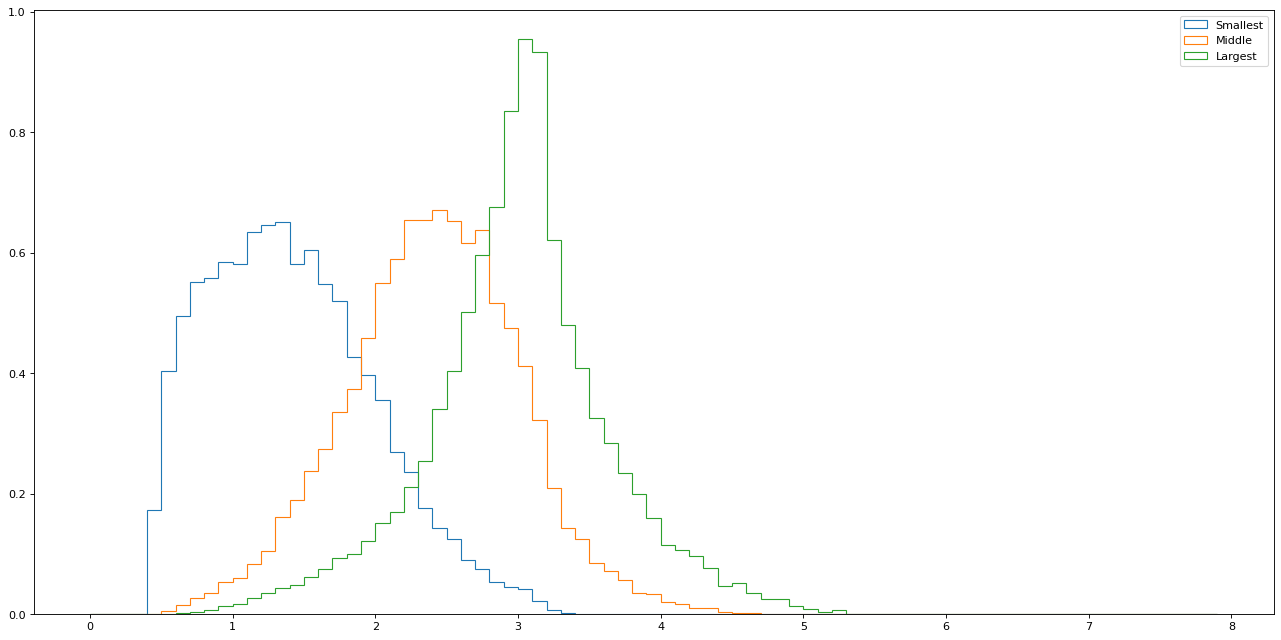

In [30]:
plt.figure(figsize=(20,10),dpi=80)
l=plt.hist(bzipdr[:,0],density=True,bins=bins1,histtype='step')
l=plt.hist(bzipdr[:,1],density=True,bins=bins1,histtype='step')
l=plt.hist(bzipdr[:,2],density=True,bins=bins1,histtype='step')
plt.legend(['Smallest','Middle','Largest'])

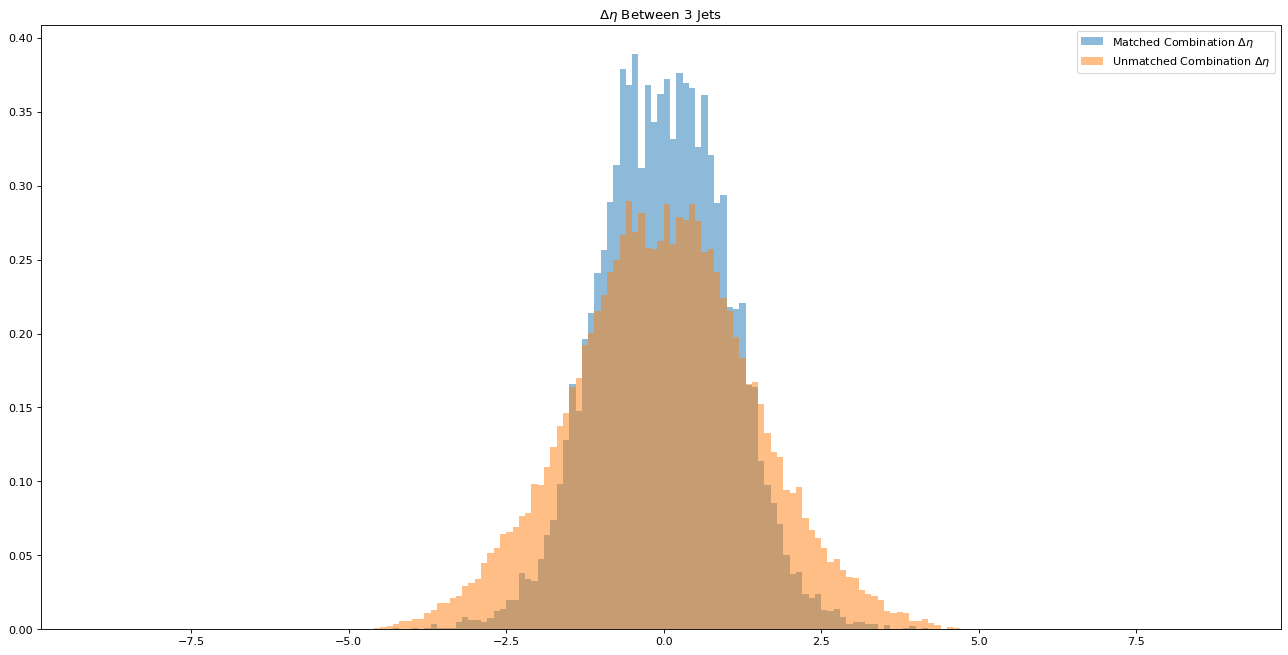

<Figure size 432x288 with 0 Axes>

In [31]:
geta23=good_vals['1'].eta-good_vals['2'].eta
geta13=good_vals['0'].eta-good_vals['2'].eta
geta12=good_vals['0'].eta-good_vals['1'].eta
geta=ak.concatenate([geta23,geta12,geta13])
beta12=bad_vals['0'].eta-bad_vals['1'].eta
beta23=bad_vals['1'].eta-bad_vals['2'].eta
beta13=bad_vals['0'].eta-bad_vals['2'].eta
beta=ak.concatenate([beta23,beta12,beta13])
plt.figure(figsize=(20,10),dpi=80)
bins1=[]
n=-90
while n<90:
    bins1.append(n*.1)
    n=n+1
l=plt.hist(geta,alpha=.5,density=True,bins=bins1)
l=plt.hist(beta,alpha=.5,density=True,bins=bins1)
plt.legend(["Matched Combination $ \Delta \eta $","Unmatched Combination $ \Delta \eta $"])
plt.title("$ \Delta \eta $ Between 3 Jets")
plt.show()
plt.savefig("deltaeta.png")

$ \Delta R $ of the unmatched data favors a Delta R between jets. Noticeably:

In [32]:
print("%.2f percent of the matched combos Delta R falls below 4" %(len(gdelta[gdelta<4])/len(gdelta)*100))

99.69 percent of the matched combos Delta R falls below 4


In [33]:
gbtagSum=good_vals['0'].btagDeepB+good_vals['2'].btagDeepB+good_vals['1'].btagDeepB
bbtagSum=bad_vals['0'].btagDeepB+bad_vals['2'].btagDeepB+bad_vals['1'].btagDeepB

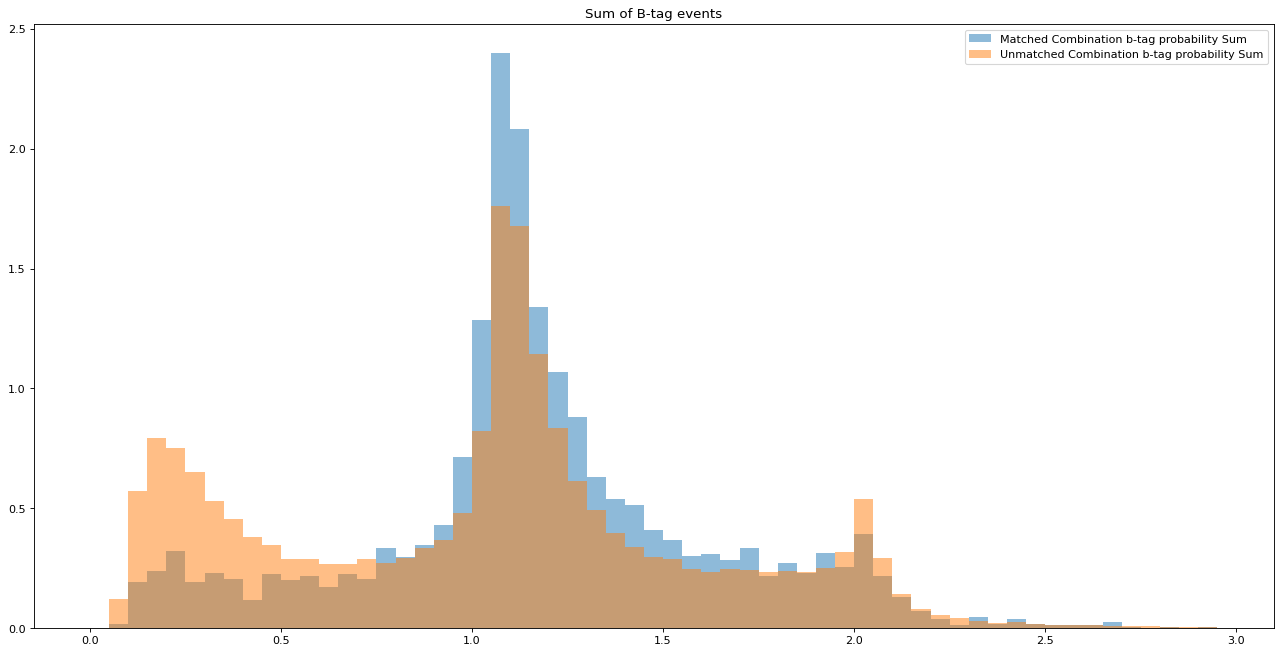

In [34]:
bins1=[]
n=0
while n<60:
    bins1.append(n*.05)
    n=n+1
plt.figure(figsize=(20,10),dpi=80)
l=plt.hist(gbtagSum,alpha=.5,density=True,bins=bins1)
l=plt.hist(bbtagSum,alpha=.5,density=True,bins=bins1)
plt.title("Sum of B-tag events")
plt.legend(["Matched Combination b-tag probability Sum","Unmatched Combination b-tag probability Sum"])

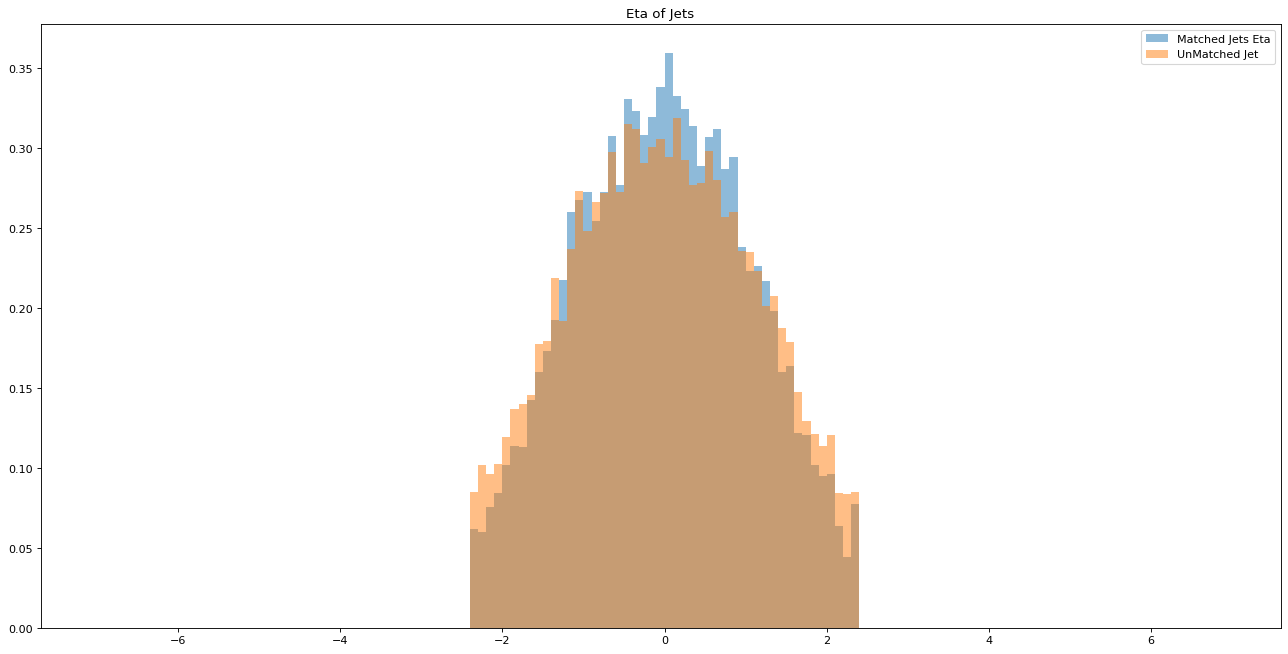

In [35]:
geta=ak.concatenate([good_vals['0'].eta,good_vals['1'].eta,good_vals['2'].eta])
beta=ak.concatenate([bad_vals['0'].eta,bad_vals['1'].eta,bad_vals['2'].eta])
plt.figure(figsize=(20,10),dpi=80)
bins1=[]
n=-70
while n<70:
    bins1.append(n*.1)
    n=n+1
l=plt.hist(geta,alpha=.5,density=True,bins=bins1)
l=plt.hist(beta,alpha=.5,density=True,bins=bins1)
plt.title("Eta of Jets")
plt.legend(["Matched Jets Eta","UnMatched Jet"])

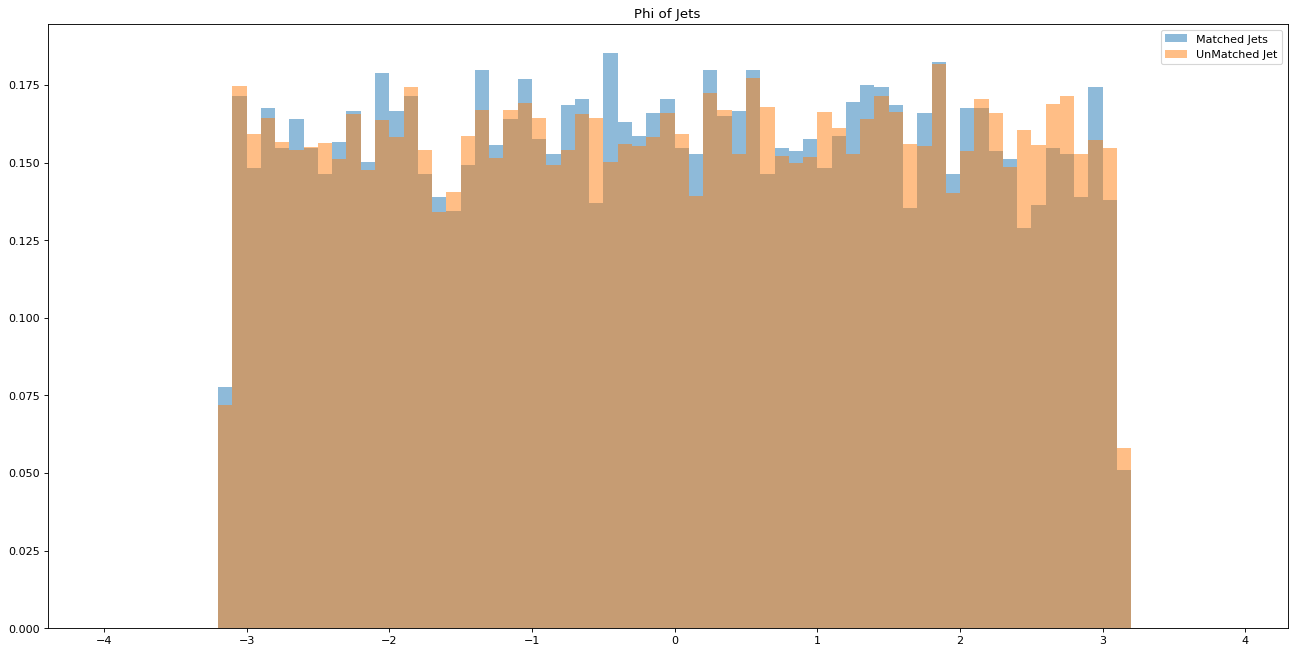

In [36]:
geta=ak.concatenate([good_vals['0'].phi,good_vals['1'].phi,good_vals['2'].phi])
beta=ak.concatenate([bad_vals['0'].phi,bad_vals['1'].phi,bad_vals['2'].phi])
plt.figure(figsize=(20,10),dpi=80)
bins1=[]
n=-40
while n<40:
    bins1.append(n*.1)
    n=n+1
l=plt.hist(geta,alpha=.5,density=True,bins=bins1)
l=plt.hist(beta,alpha=.5,density=True,bins=bins1)
plt.title("Phi of Jets")
plt.legend(["Matched Jets","UnMatched Jet"])

In [37]:
#Zipping Event into .csv file

In [38]:
j1,j2,j3=ak.unzip(jetcombos)
dR1_2=j1.delta_r(j2)
dR1_3=j1.delta_r(j3)
dR2_3=j2.delta_r(j3)
j1b_tag=j1.btagCSVV2
j2b_tag=j1.btagCSVV2
j3b_tag=j1.btagCSVV2
j1area=j1.area
j2area=j2.area
j3area=j3.area
j1p4=ak.zip({"pt":j1.pt,"phi":j1.phi,"eta":j1.eta,"mass":j1.mass},with_name="PtEtaPhiMLorentzVector")
j2p4=ak.zip({"pt":j2.pt,"phi":j2.phi,"eta":j2.eta,"mass":j2.mass},with_name="PtEtaPhiMLorentzVector")
j3p4=ak.zip({"pt":j3.pt,"phi":j3.phi,"eta":j3.eta,"mass":j2.mass},with_name="PtEtaPhiMLorentzVector")
processedMLdata=ak.zip({"j1p4":j1p4,"j2p4":j2p4,"j3p4":j3p4,
                        "dR12":dR1_2,"dR13":dR1_3,"dR23":dR2_3,
                       "j1btag":j1b_tag,"j2btag":j2b_tag,"j3btag":j3b_tag})

In [39]:
len(jetcombos['0'])

65243

In [40]:
len(jetcombos['0'][jetcombos['1'].pt<=jetcombos['2'].pt])

42

In [87]:
df=ak.to_pandas(processedMLdata)
df.to_csv("data/ML_data.csv",index=False)
vf=ak.to_pandas(trutharray)
vf.to_csv("data/Valid_data.csv",index=False)

## To Do:
* PreProcessing Coffea Processor
* Use Boosted Decision Tree
* Compare Efficiency to simple data cuts

# Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

AOD DATA GUIDE: https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideAodDataTable

 # Storage Cells

In [379]:
test_events=finalJets[0:3]
testqqb=qqb[0:3]
print(testqqb)

[[GenParticle, GenParticle, GenParticle], ... GenParticle, GenParticle, GenParticle]]


In [380]:
matchedTest=testqqb.nearest(test_events)
print("Matched Reconstructed Jets(pt,eta,phi,mass)")
n=0
while n<=2:
    print("Event %i"%(n+1))
    for j in matchedTest[n]:
        print("(%.2f,%.2f,%.2f,%.2f)"%(j.pt,j.eta,j.phi,j.mass),end="")
        print("")
    n+=1
print("Matched GenJetIdx")
n=0
while n<=2: 
    string=str(n)+" Idx: {:^5}"
    print(string.format(str(matchedTest[n].genJetIdx)))
    n+=1
print("Event # -> (GenPart Jet Lorenz Vector -> pt,eta,phi,mass)")
n=0
while n<=2:
    print("Event %i"%(n+1))
    for j in testqqb[n]:
        print("(%.2f,%.2f,%.2f,%.2f)"%(j.pt,j.eta,j.phi,j.mass),end="")
        print("")
    n+=1

Matched Reconstructed Jets(pt,eta,phi,mass)
Event 1
(122.69,0.45,-2.92,12.10)
(31.91,0.26,-0.62,5.50)
(36.22,1.40,-3.07,6.86)
Event 2
(70.00,1.04,2.32,12.52)
(42.56,0.73,0.65,7.44)
(70.00,1.04,2.32,12.52)
Event 3
(30.88,-1.02,1.25,6.12)
(111.62,-0.23,2.92,13.02)
(38.88,0.75,2.24,5.54)
Matched GenJetIdx
0 Idx: [0, 4, 3]
1 Idx: [2, 3, 2]
2 Idx: [3, 1, 2]
Event # -> (GenPart Jet Lorenz Vector -> pt,eta,phi,mass)
Event 1
(138.00,0.43,-2.91,0.00)
(2.49,0.14,-1.22,0.00)
(26.44,1.40,-3.05,0.00)
Event 2
(3.87,1.61,-2.98,0.00)
(37.88,0.72,0.69,0.00)
(12.12,0.88,2.20,0.00)
Event 3
(36.38,-1.04,1.27,0.00)
(67.75,-0.22,2.91,0.00)
(9.47,0.76,2.33,0.00)


In [381]:
print("Event # -> (pt,eta,phi,mass)")
n=0
while n<=2:
    print("Event %i"%(n+1))
    string=str(n)+" pt: {:^10} "+"eta: {:^10} "+ "phi: {:^10}" + " mass: {:^10}"
    for j in test_events[n]:
        print("(%.2f,%.2f,%.2f,%.2f)"%(j.pt,j.eta,j.phi,j.mass),end="")
        print("")

    n+=1

Event # -> (pt,eta,phi,mass)
Event 1
(122.69,0.45,-2.92,12.10)
(87.88,1.21,-0.46,9.11)
(44.44,0.70,1.44,4.21)
(36.22,1.40,-3.07,6.86)
(31.91,0.26,-0.62,5.50)
Event 2
(74.38,0.98,-1.61,14.87)
(70.00,1.04,2.32,12.52)
(60.91,-0.89,0.35,10.65)
(42.56,0.73,0.65,7.44)
(38.28,-0.62,2.23,5.14)
Event 3
(111.62,-0.23,2.92,13.02)
(109.50,-0.54,-0.86,5.71)
(38.88,0.75,2.24,5.54)
(30.88,-1.02,1.25,6.12)
